In [54]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import optimize

import folium
from IPython.display import Image

In [2]:
import ee

# Trigger the authentication flow.
ee.Authenticate()

# Initialize the library.
ee.Initialize(project='satvis-425514')

In [6]:
# Import the MODIS land cover collection.
lc = ee.ImageCollection('MODIS/006/MCD12Q1')

# Import the MODIS land surface temperature collection.
lst = ee.ImageCollection('MODIS/006/MOD11A1')

# Initial date of interest (inclusive).
i_date = '2017-01-01'

# Final date of interest (exclusive).
f_date = '2020-01-01'

# Selection of appropriate bands and dates for LST.
lst = lst.select('LST_Day_1km', 'QC_Day').filterDate(i_date, f_date)

In [7]:
# Define the urban location of interest as a point near Lyon, France.
buc_lon = 26.0963
buc_lat = 44.4396
buc_poi = ee.Geometry.Point(buc_lon, buc_lat)

# Define the rural location of interest as a point away from the city.
corbii_lon = 25.2945
corbii_lat = 44.3237 
corbii_poi = ee.Geometry.Point(corbii_lon, corbii_lat)

# Temperature Analysis

In [44]:
scale = 1000

lst_buc_poi = lst.getRegion(buc_poi, scale).getInfo()
lst_corbii_poi = lst.getRegion(corbii_poi, scale).getInfo()

# len(lst_buc_poi)

lst_corbii_poi[:5]

[['id', 'longitude', 'latitude', 'time', 'LST_Day_1km', 'QC_Day'],
 ['2017_01_01', 25.292066824385127, 44.32736769487779, 1483228800000, None, 2],
 ['2017_01_02',
  25.292066824385127,
  44.32736769487779,
  1483315200000,
  13782,
  0],
 ['2017_01_03', 25.292066824385127, 44.32736769487779, 1483401600000, None, 2],
 ['2017_01_04',
  25.292066824385127,
  44.32736769487779,
  1483488000000,
  13763,
  0]]

In [45]:
def ee_array_to_df(arr, list_of_bands):
    """Transforms client-side ee.Image.getRegion array to pandas.DataFrame."""
    df = pd.DataFrame(arr)

    # Rearrange the header.
    headers = df.iloc[0]
    df = pd.DataFrame(df.values[1:], columns=headers)

    # Remove rows without data inside.
    df = df[['longitude', 'latitude', 'time', *list_of_bands]].dropna()

    # Convert the data to numeric values.
    for band in list_of_bands:
        df[band] = pd.to_numeric(df[band], errors='coerce')

    # Convert the time field into a datetime.
    df['datetime'] = pd.to_datetime(df['time'], unit='ms')

    # Keep the columns of interest.
    df = df[['time','datetime',  *list_of_bands]]

    return df

def t_modis_to_celsius(t_modis):
    t_celsius = 0.02*t_modis - 273.15
    return t_celsius


In [46]:
lst_df_buc = ee_array_to_df(lst_buc_poi, ['LST_Day_1km'])
lst_df_buc['LST_Day_1km'] = lst_df_buc['LST_Day_1km'].apply(t_modis_to_celsius)

lst_df_corbii = ee_array_to_df(lst_corbii_poi, ['LST_Day_1km'])
lst_df_corbii['LST_Day_1km'] = lst_df_corbii['LST_Day_1km'].apply(t_modis_to_celsius)

lst_df_corbii.head()

,time,datetime,LST_Day_1km
1,1483315200000,2017-01-02,2.49
3,1483488000000,2017-01-04,2.11
11,1484179200000,2017-01-12,-13.55
14,1484438400000,2017-01-15,-9.59
19,1484870400000,2017-01-20,-9.21


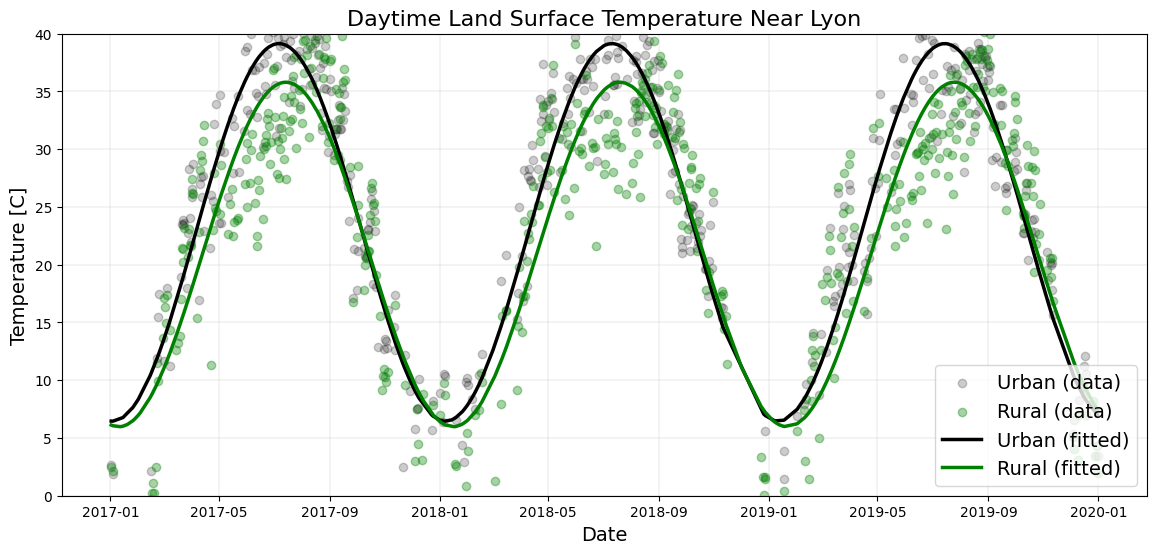

In [50]:
%matplotlib inline

x_data_buc = np.asanyarray(lst_df_buc['time'].apply(float))
x_data_corbii = np.asanyarray(lst_df_corbii['time'].apply(float))

y_data_buc = np.asanyarray(lst_df_buc['LST_Day_1km'].apply(float))
y_data_corbii = np.asanyarray(lst_df_corbii['LST_Day_1km'].apply(float))

def fit_func(t, lst0, delta_lst, tau, phi):
    return lst0 + (delta_lst/2)*np.sin(2*np.pi*t/tau + phi)

lst0 = 20
delta_lst = 40
tau = 365*24*3600*1000
phi = 2*np.pi*4*30.5*3600*1000/tau

params_buc, params_covariance_buc = optimize.curve_fit(
    fit_func, x_data_buc, y_data_buc, p0=[lst0, delta_lst, tau, phi])
params_corbii, params_covariance_corbii = optimize.curve_fit(
    fit_func, x_data_corbii, y_data_corbii, p0=[lst0, delta_lst, tau, phi])

fig, ax = plt.subplots(figsize=(14, 6))

ax.scatter(lst_df_buc['datetime'], lst_df_buc['LST_Day_1km'],
           c='black', alpha=0.2, label='Urban (data)')
ax.scatter(lst_df_corbii['datetime'], lst_df_corbii['LST_Day_1km'],
           c='green', alpha=0.35, label='Rural (data)')

# Add fitting curves.
ax.plot(lst_df_buc['datetime'],
        fit_func(x_data_buc, params_buc[0], params_buc[1], params_buc[2], params_buc[3]),
        label='Urban (fitted)', color='black', lw=2.5)
ax.plot(lst_df_corbii['datetime'],
        fit_func(x_data_corbii, params_corbii[0], params_corbii[1], params_corbii[2], params_corbii[3]),
        label='Rural (fitted)', color='green', lw=2.5)

# Add some parameters.
ax.set_title('Daytime Land Surface Temperature Near Lyon', fontsize=16)
ax.set_xlabel('Date', fontsize=14)
ax.set_ylabel('Temperature [C]', fontsize=14)
ax.set_ylim(-0, 40)
ax.grid(lw=0.2)
ax.legend(fontsize=14, loc='lower right')

plt.show()

# Maps

In [65]:
roi = buc_poi.buffer(1e5)

In [62]:
lst_img = lst.mean().select('LST_Day_1km').multiply(0.02).add(-273.15)

url = lst_img.getThumbUrl({
    'min': 10, 'max': 30, 'dimensions':512, 'region': roi,
    'palette': ['blue', 'yellow', 'orange', 'red']})

print(url)
print('\nWait while loading...')
Image(url=url)

https://earthengine.googleapis.com/v1/projects/satvis-425514/thumbnails/58213504bbca43070f9deea301aba650-181f83fa0a1ba974f03e71548e6be89d:getPixels

Wait while loading...


In [68]:
lc_img = lc.select('LC_Type1').filterDate(i_date).first()

url = lc_img.getThumbUrl({
    'min': 1,'max': 17, 'dimensions':2048, 'region': roi,
    'palette': ['05450a','086a10', '54a708', '78d203', '009900', 'c6b044',
                'dcd159', 'dade48', 'fbff13', 'b6ff05', '27ff87', 'c24f44',
                'a5a5a5', 'ff6d4c', '69fff8', 'f9ffa4', '1c0dff']
})

print(url)
print('\nWait while loading...')
Image(url=url)

https://earthengine.googleapis.com/v1/projects/satvis-425514/thumbnails/e00d5fd645f3ed543e9ba741c27da412-ffed9fc68a89f4c97ff4a9c3dcaa72c7:getPixels

Wait while loading...
